In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import reduce, partial
import scipy
from typing import Tuple
from importlib import reload
from cycler import cycler
from itertools import chain
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 get_segments)


from writhe_tools.plots import (
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot,
                                build_matrix_boxplot_grid,
                                lineplot1D)

from writhe_tools.tcca import CCA, tCCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans, rotate_points, acf, pmf


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,                                 
                                   to_contacts
                                    )


from writhe_tools.utils import (lsdir,
                                group_by,
                                reindex_list,
                                contiguous_bool,
                                to_numpy,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )


from typing import Dict, List, Tuple


import warnings
warnings.filterwarnings("ignore")



fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )



def fill_1d(x, values, indices):
    x[indices] = values
    return x

def fill(x, index, val):
    x[:, index] = val
    return x

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

ternary_bool = lambda distances : prod([to_contacts(i, 1).any(1) for i in split(distances)])

isin_index = lambda x, y : np.where(np.isin(x, y))[0]




def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              lower_upper: bool = False,
              method: str = "percentile",
              statistic: callable=np.mean) -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=statistic,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data) if data.ndim == 1 else data.mean(0)
    error = [res.confidence_interval.low, res.confidence_interval.high] if lower_upper\
            else (res.confidence_interval.high - res.confidence_interval.low) / 2
    if data.ndim > 1:error = np.stack(error)
    
    return mean, error


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter
def block_error(x: np.ndarray, lower_upper: bool = False):
    """
    x : (N, d) numpy array with d features and N measurements
    """
    n = x.shape[0]
    blocks = reblock(x.T)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    optimal_indices=optimal_indices.astype(int)
    #op
    #print(optimal_indices[0])
    if x.ndim == 1:
        return lu_from_error(x.mean(), blocks[optimal_indices[0]].std_err.item()) if lower_upper else\
                (x.mean(), blocks[optimal_indices[0]].std_err.item())
    else:
        return lu_from_error(x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))\
                if lower_upper else (x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))

def lu_from_error(mean, error):
    if all(isinstance(i, (float, int)) for i in (mean, error)):
        mean, error = [mean], [error]
    return mean, np.array([[mu - err, mu + err] for mu, err in zip(mean, error)]).T

# convenience (hard coded to 2 monomers) function to combine stats and prop error for averages to be taken over both monomers
def monomer_aggr_stats(x, 
                       error:callable=block_error, 
                       lower_upper: bool = False, 
                       fill_bool:np.ndarray=None):
    # compue mean and error over both monomers, aggregate, fill zeros for plotting, give lower, upper errors or absolute error
    ave, err = error(x, lower_upper=False)
    ave = np.add.reduce(split(x.mean(0))) / 2
    err = np.linalg.norm(err.reshape(2, -1), axis=0) / 2
    
    if lower_upper:
        # very simple error propogation here (arguably too simple)
        err = lu_from_error(ave, err)[-1]                   
        if fill_bool is not None:
            ave = fill_1d(np.zeros(len(fill_bool)), ave, fill_bool)
            err = np.stack([fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in err])

        return ave, err


    return (ave, err) if fill_bool is None else [fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in [ave, err]]


#block_error(np.arange(10000), lower_upper=False)
path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
helix_pdb = '/data/r1r2/monomer_r1r2_helix.pdb'

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]


[writhe_tools] ⏭️ Skipping 'graph_utils' (missing: torch_geometric)
[writhe_tools] 👉 To enable this module, install: pip install writhe-tools[graph]


# Computations

In [2]:
# protein only calculations
label = 'APO'
ca_selection = md.load(protein_pdb).top.select('name CA')
sequence, ca_index = get_residues(md.load(protein_pdb))
# 1 letter codes for the monomer sequence (just 1)
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]

unitcell_lengths = md.load(protein_files[0], top=protein_pdb).unitcell_lengths


ca_distances = ResidueDistances(index_0=np.arange(24),
                                index_1=np.arange(24, 48),
                                traj=md.load(protein_files[0], top=protein_pdb, atom_indices=ca_selection)
                               )

# dimer events from ca_distances
dimer = ca_distances.contacts(1).any(1)
dimer_events = contiguous_bool(bools=dimer)
dimer_lengths = 0.24 * np.fromiter(map(len, dimer_events), float) # scale by physical time

# sort by event length
sort = dimer_lengths.argsort()[::-1]
dimer_events = reindex_list(dimer_events, sort)
dimer_lengths = dimer_lengths[sort]

# structural features
sa = np.stack([calc_sa(md.load(protein_files[0], top=protein_pdb, atom_indices=j), helix_pdb) for j in split(ca_selection)])

dssp = np.where(md.compute_dssp(traj=md.load(protein_files[0], top=protein_pdb)) == 'H', 1, 0)[:, ca_index]

writhe = Writhe(xyz=md.load(protein_files[0], top=protein_pdb, atom_indices=ca_selection).center_coordinates().xyz)
segments = np.concatenate([get_segments(index0=np.arange(24)),
                           get_segments(index0=np.arange(24, 48)),
                           get_segments(index0=np.arange(24), index1=np.arange(24, 48))
                          ])

writhe_features = writhe.compute_writhe(segments=segments,
                                        cuda=True,
                                        store_results=False,
                                        #lengths=unitcell_lengths,
                                        )['writhe_features']
# dimensionality reduction (don't use this if you don't have truly continuous data
tcca = tCCA(writhe_features, lag=10, dim=2,).fit()

# for non-continuous data (replica exchange, metaD, etc, ..) for PCA (or whatever else you want)

# compute the projection and then align to a reference because eigen vects might have flipped sign
proj = tcca.transform(writhe_features); proj = rotate_points(np.load(lsdir(paths[0], keyword='writhe_tcca_lag_')[0])[1:, :2],
                                                             proj, so3=False)

# to cluster with Kmeans
# dtraj, frames_cl = Kmeans(proj, n_clusters=7, n_dim=2)

# Kmeans isn't deterministic, so we use a pre computed clustering to keep consistency with reported values

## WARNING - MUST HAVE REFERNECE AVAILABLE FOR THIS TO WORK - CAN JUST COMMENT THIS OUT AND RECLUSTER USING LINES ABOVE
dtraj = load_dict('density_clusters.pkl')[0]; frames_cl = group_by(dtraj)
centroids = group_by(dtraj, proj, reduction = partial(np.mean, axis = 0))


 # Visualize latent space

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

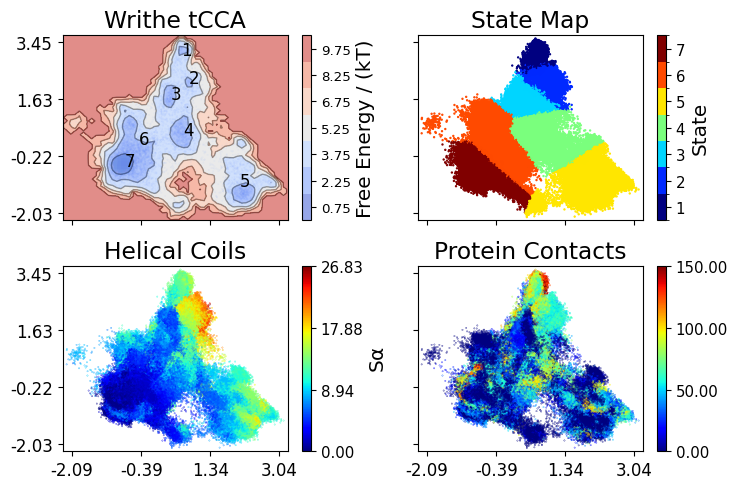

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(7.5, 5), sharey=True, sharex=True)
ax=ax.flat
fes2d(proj,
      cluster_centers=centroids,
      ax=ax[0],
      **fes2d_args,
      title='Writhe tCCA',
      font_scale=1.2)

proj2d(proj, 
       ax=ax[1],
       c=dtraj,
       state_map=True,
       title = 'State Map',
       font_scale=1.2)

proj2d(proj,  ax=ax[2], c=sa.sum((0,2)),
       cmap='jet', title = 'Helical Coils',
       font_scale=1.2,dot_size=.05,
       vmin=0, cbar_label=r'S$\alpha$')

proj2d(proj, 
       ax=ax[3],
       c=ca_distances.contacts(1).sum(-1),
       cmap='jet',
       title = 'Protein Contacts',
       font_scale=1.2,
       vmin=0,vmax=150,
       dot_size=.05)

fig.tight_layout()
fig.savefig(f'{paths[0]}/projections.png',
            dpi=1000, bbox_inches='tight')

 # protein contacts (CA-CA distance < 1 nm) and helical propensities (DSSP algorithm)

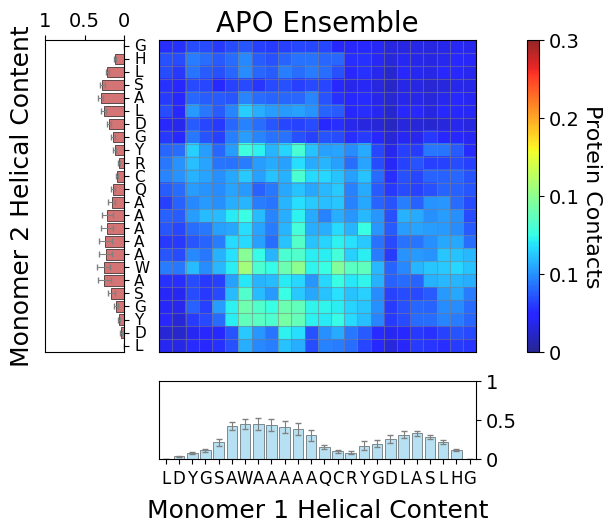

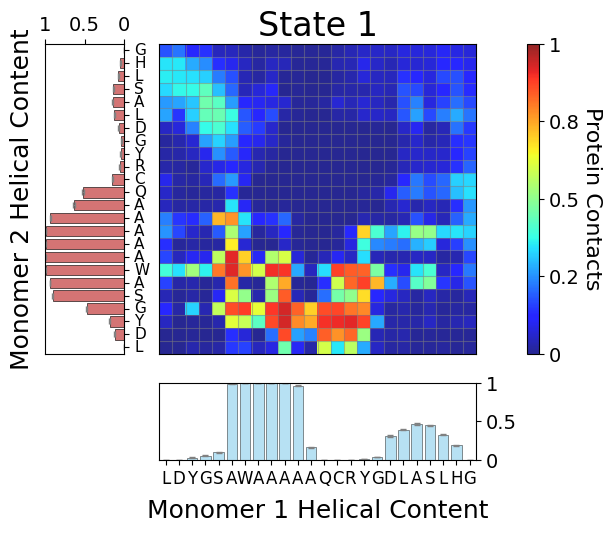

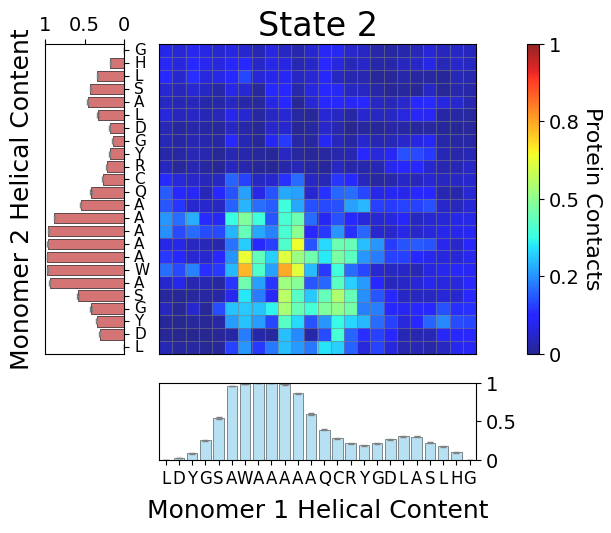

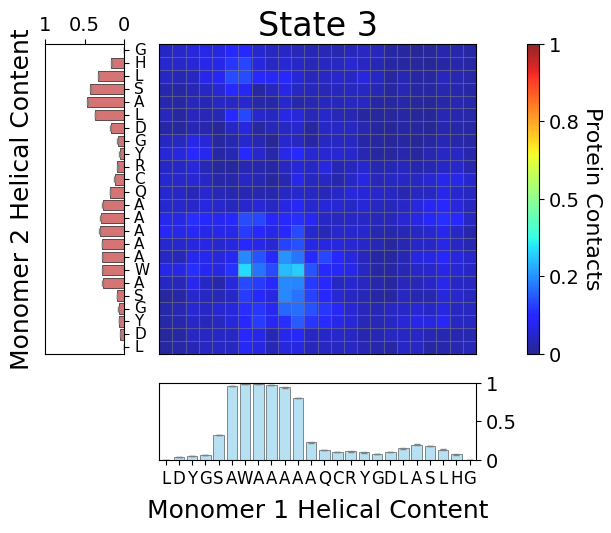

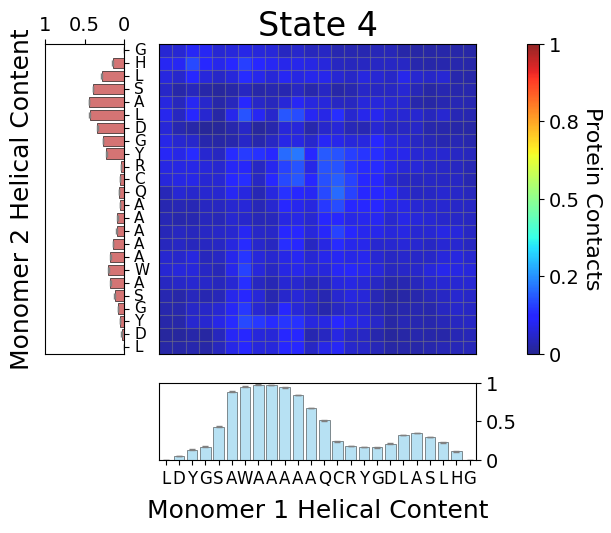

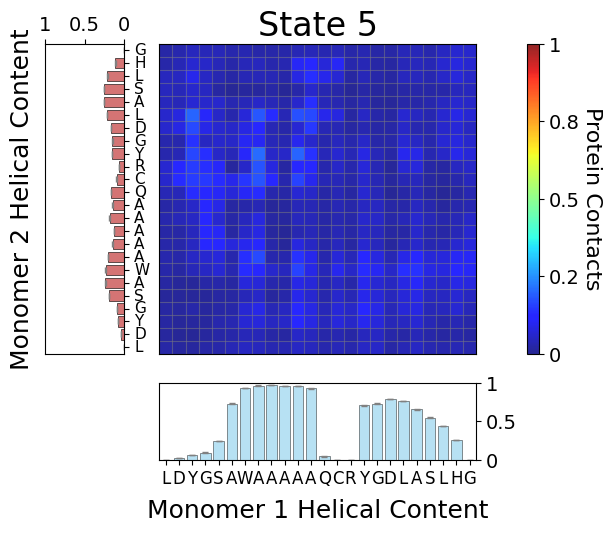

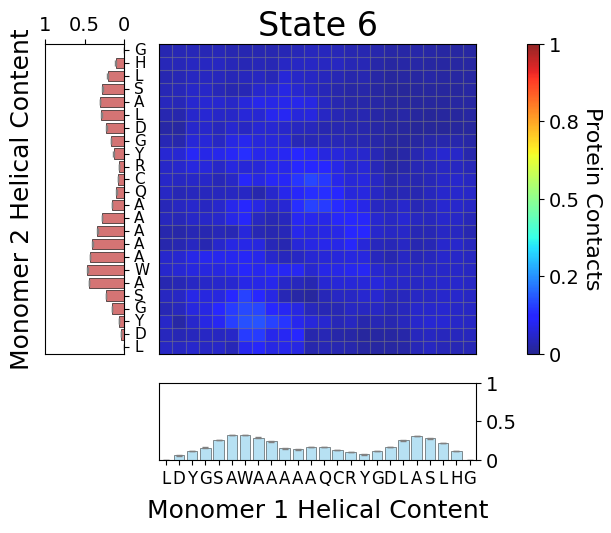

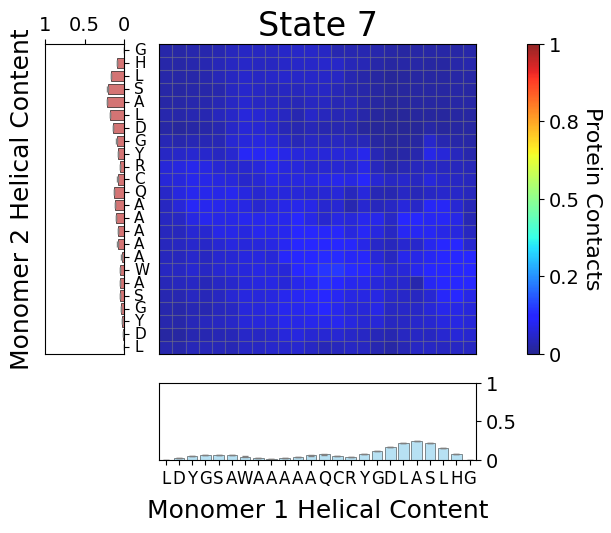

In [4]:
import writhe_tools
reload(writhe_tools)
reload(writhe_tools.plots)
from writhe_tools.plots import build_matrix_boxplot_grid
dssp_error = split(block_error(dssp)[1])
build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1).mean(0).T,
                          dssp[:,:24].mean(0),
                          dssp[:,24:].mean(0),
                          bottom_errors=dssp_error[0],
                          left_errors=dssp_error[1],
                          cmap='jet',
                          title=f'{label} Ensemble',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=.3,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          ecolor='gray',
                          path=f'{paths[0]}/protein_protein_helix_ensemble.png'
                         )
for i, frames in enumerate(frames_cl):
    dssp_error = split(bootstrap(dssp[frames], 0.95)[1])

    build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1, index=frames).mean(0).T,
                          dssp[frames, :24].mean(0),
                          dssp[frames, 24:].mean(0),
                          title_size=24,
                          bottom_errors=dssp_error[0],
                          left_errors=dssp_error[1],
                          cmap='jet',
                          title=f'State {i+1}', #f'{label} : State {i+1}',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=1,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          path=f'{paths[0]}/protein_protein_helix_state_{i+1}.png')
    


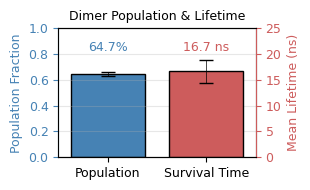

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# --- helper: shift all x-positions for artists on an Axes (boxes, whiskers, errorbars)
def _shift_x(ax, dx):
    # patches (boxes)
    for p in ax.patches:
        p.set_x(p.get_x() + dx)

    # standard lines (medians, caps, etc.)
    for ln in ax.lines:
        xd = ln.get_xdata()
        if xd is not None and len(np.atleast_1d(xd)):
            ln.set_xdata(np.asarray(xd) + dx)

    # collections (whiskers/errorbars often stored as LineCollection)
    for coll in ax.collections:
        if isinstance(coll, LineCollection):
            segs = coll.get_segments()
            if segs:
                coll.set_segments([seg + np.array([dx, 0]) for seg in segs])
        elif hasattr(coll, "get_offsets"):
            offs = coll.get_offsets()
            if offs is not None and len(offs):
                coll.set_offsets(offs + np.array([dx, 0]))

fig, ax1 = plt.subplots(figsize=(3.2, 2))

# --- Left axis: dimer population fraction (steelblue) ---
mu_pop, err_pop = block_error(dimer)
box_plot(
    [mu_pop],
    errors=[err_pop],
    labels=['Population'],
    error_capsize=5,
    error_linewidth=.5,
    error_capthick=1,
    error_color='black',
    color_list=['steelblue'],
    alpha=1,
    font_scale=state_font_scale,
    title='Dimer Population & Lifetime',
    rotation=0,
    trunc=trunc,
    pre_trunc=pre_trunc,
    ymin=0,
    ymax=1,
    width=0.45,
    ax=ax1
)
ax1.set_ylabel('Population Fraction', color='steelblue')
ax1.tick_params(axis='y', colors='steelblue')
ax1.spines['left'].set_color('steelblue')

# --- Right axis: mean dimer lifetime (indianred) ---
ax2 = ax1.twinx()
mu_life = np.mean(dimer_lengths)
err_life = bootstrap(dimer_lengths)[-1]
box_plot(
    [mu_life],
    errors=[err_life],
    labels=['Survival Time'],
    error_capsize=5,
    error_linewidth=.5,
    error_capthick=1,
    error_color='black',
    color_list=['indianred'],
    alpha=1,
    font_scale=state_font_scale,
    rotation=0,
    trunc=trunc,
    pre_trunc=pre_trunc,
    ymin=0,
    ymax=25,
    width=0.45,
    ax=ax2
)
ax2.set_ylabel('Mean Lifetime (ns)', color='indianred')
ax2.tick_params(axis='y', colors='indianred')
ax2.spines['right'].set_color('indianred')

# --- Separate the boxes on x: slide left-axis box left, right-axis box right ---
left_x, right_x = -0.3, +0.3
_shift_x(ax1, left_x)
_shift_x(ax2, right_x)

# --- X ticks/labels aligned with box centers; hide twin x-ticks
ax1.set_xlim(-0.6, 0.6)
ax1.set_xticks([left_x, right_x])
ax1.set_xticklabels(['Population', 'Survival Time'])
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Grid + annotations (colors match axes)
ax1.grid(True, alpha=0.3, axis='y')
yl1 = ax1.get_ylim(); yl2 = ax2.get_ylim()
ax1.text(left_x, yl1[0] + 0.8*(yl1[1]-yl1[0]), f'{100*mu_pop:.1f}%',
         color='steelblue', ha='center', va='bottom', fontsize=9)
ax2.text(right_x, yl2[0] + 0.80*(yl2[1]-yl2[0]), f'{mu_life:.1f} ns',
         color='indianred', ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()


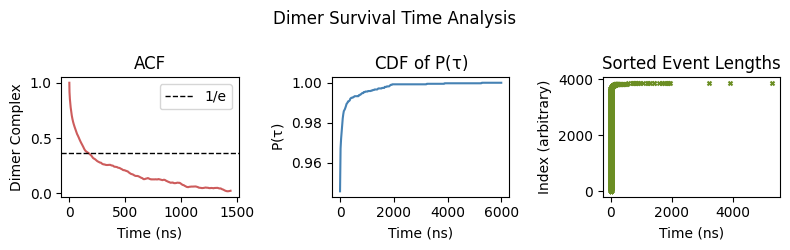

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))

ac = acf(dimer)
#get the correlation time
#tau.append(get_tau(ac))
axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
             ac[:6000],
             c="indianred",
            )
bins=300
axes[1].plot( np.linspace(0, 6000, bins), np.cumsum(pmf(dimer_lengths, bins=bins, range=(0, 6000))[0]), c='steelblue')
axes[2].scatter(dimer_lengths[::-1], np.arange(len(dimer_lengths)), c='olivedrab', s=8, marker='x')



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
#axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("Dimer Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Dimer Survival Time Analysis')
fig.tight_layout()

# Folding Upon Binding?

Text(0.5, 1.0, 'S$\\alpha$(t) * Protein Contacts(t + $\\tau$)')

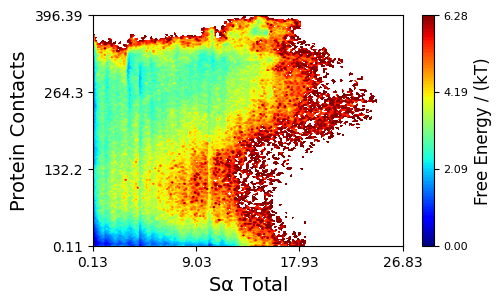

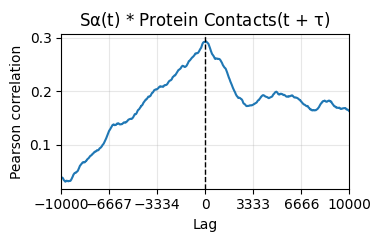

In [7]:
from writhe_tools.writhe_numba import pbc_correct
from writhe_tools.stats import cross_correlation, plot_cross_correlation
fes2d(sa.sum((0,-1)), np.exp(-.25 * ca_distances.distances**2).sum(-1), xlabel=r'S$\alpha$'+" Total", ylabel="Protein Contacts")
dist = np.power(pbc_correct(writhe.xyz[:, :24].mean(1) - writhe.xyz[:, 24:].mean(1), unitcell_lengths), 2).sum(-1)**(1/2)
lags, corr = cross_correlation(sa.sum((0,-1)),
                                       #ca_distances.contacts(1).mean(-1),
                                       np.exp(-.25 * ca_distances.distances**2).mean(-1),
                                     )
ax=plt.subplots(1, 1,figsize=(4, 2.5))[-1]
plot_cross_correlation(lags, corr, 10000, normalize=False, ax=ax)
ax.set_title(r'S$\alpha$(t) * Protein Contacts(t + $\tau$)')

Text(0.5, 1.0, 'Event Protein Contact distributions')

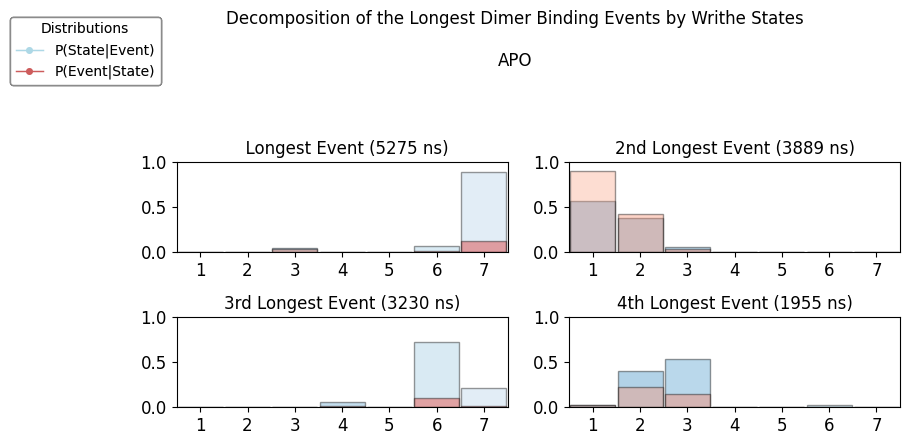

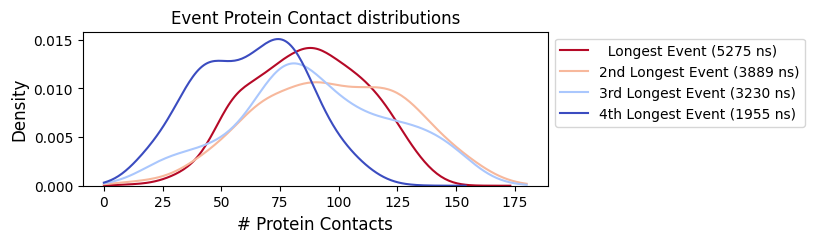

In [8]:
import seaborn as sns
fig, axes = plt.subplots(2,2, figsize=(8, 4))
event_title = dict(zip([0, 1, 2, 3], ' ,2nd,3rd,4th'.split(',')))
for i, (frames, length, ax) in enumerate(zip(dimer_events, dimer_lengths, axes.flat)):

    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)
    
    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1,
            title = f'{event_title[i]} Longest Event ({length:.0f} ns)')
    
    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
    fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1.1])
    
    fig.suptitle(f"Decomposition of the Longest Dimer Binding Events by Writhe States\n\n{label}", y=1.1)

fig.tight_layout()




fig, ax = plt.subplots(1, 1, figsize=(6,2))
for i, (frames, length, color) in enumerate(zip(dimer_events[:4], dimer_lengths, get_color_list(4,'coolwarm_r'))):
    
    sns.kdeplot(ca_distances.contacts(1)[frames].sum(-1),
                label=f'{event_title[i]} Longest Event ({length:.0f} ns)',
                common_grid=True,
                ax=ax,
                clip=(0,180),
                bw_adjust=2,
                color=color)

ax.legend(ncol=1, bbox_to_anchor=[1,1])
ax.set_xlabel('# Protein Contacts', size=12)
ax.set_ylabel('Density', size=12)
ax.set_title('Event Protein Contact distributions', 
                #size=15,
               )

In [8]:
import pandas
from pandas import DataFrame
from IPython.display import display, Markdown
cols = ['Population %', r'Protein Contacts',  r'$S\alpha$', 'Dimer %', 'Ligand Contacts', 'Ternary %']

rows = []

rows.append(group_by(dtraj, reduction=lambda x : 100 * x.sum() / len(dtraj)))

rows.append(group_by(dtraj,
                    ca_distances.contacts(1).sum(-1),
                    np.mean))


rows.append(group_by(dtraj, sa.sum((0, 2)), np.mean))

rows.append(100 * group_by(dtraj,
                           dimer,
                           np.mean))


display(Markdown(f'{label} State Averaged Observables'))
display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols[:4], index=np.arange(1, len(rows[0]) + 1)))
        
    

APO State Averaged Observables

,Population %,Protein Contacts,$S\alpha$,Dimer %
1,2.5,98.3,13.0,99.0
2,3.4,73.2,15.3,98.7
3,7.1,37.4,7.8,72.6
4,12.6,41.0,9.1,72.5
5,12.6,30.9,10.2,61.4
6,22.7,33.1,5.1,56.1
7,39.2,34.7,2.0,61.8


In [13]:
one_hot = np.zeros((len(dtraj), len(np.unique(dtraj))))
one_hot[np.arange(len(dtraj)), dtraj] = np.ones(len(dtraj))
mu, err = block_error(one_hot)

In [ ]:
import pandas
from pandas import DataFrame
from IPython.display import display, Markdown
cols = ['Population %', r'Protein Contacts',  r'$S\alpha$', 'Dimer %', 'Ligand Contacts', 'Ternary %']

rows = []

rows.append(group_by(dtraj, reduction=lambda x : 100 * x.sum() / len(dtraj)))

rows.append(group_by(dtraj,
                    ca_distances.contacts(1).sum(-1),
                    np.mean))

rows.append(group_by(dtraj, sa.transpose(1, 0, 2).reshape(-1, 38).sum(1), block_error))
#rows.append(group_by(dtraj, sa.sum((0, 2)), np.mean))

rows.append(100 * group_by(dtraj, dimer, block))


display(Markdown(f'{label} State Averaged Observables'))
display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols[:4], index=np.arange(1, len(rows[0]) + 1)))
        
    